In [1]:
import pandas as pd
import geopandas as gpd

## DATA RETRIEVAL 

In [2]:
# read csv data into pandas dataframe
df_gps = pd.read_csv(r'..\_gitignore\data\GPS_Occurrence_Data_ALL.csv')

C:\Users\Shane\AppData\Local\Temp\ipykernel_10620\3706976985.py:2: DtypeWarning: Columns (0,5,8,9,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df_gps = pd.read_csv(r'..\_gitignore\data\GPS_Occurrence_Data_ALL.csv')


## DATA CLEANING & EXPLORATION 

In [3]:
#df_gps.head()

In [4]:
#df_gps.describe()

In [5]:
#df_gps.info()

### DATA CLEANING

In [6]:
# Drop multiple columns by index
droprange = [0, 5, 8, 9, 10, 11, 12, 14, 13, 15] + list(range(17, 41))
df_gps.drop(df_gps.columns[droprange], axis=1, inplace=True)

In [7]:
# Drop administrative, call errors, and other non-pertinent entries
print(df_gps.shape)
admin_calls = df_gps.dropna(subset=['DispatchType'])
admin_calls = admin_calls[admin_calls['DispatchType'].str.contains('ADMINISTRATIVE')]
print(admin_calls.shape)

df_gps = df_gps[df_gps['DispatchType'].str.contains('ADMINISTRATIVE')==False]
print(df_gps.shape)

(550072, 7)
(103940, 7)
(446123, 7)


In [8]:
df_gps['ReportedDate'] = df_gps['ReportedDate'].fillna(0)
df_gps['ReportedTime'] = df_gps['ReportedTime'].fillna(0)

In [9]:
# Drop null values for only specifc columns
df_gps = df_gps.dropna(subset=['Address'])
df_gps = df_gps.dropna(subset=['City'])

In [ ]:
# Remove leading white spaces from Address column
df_gps['Address'] = df_gps['Address'].str.strip()

In [10]:
# drop city entries not equal to GUELPH
df_gps = df_gps[df_gps.City == 'GUELPH']

#### CLEAN UP DATE & TIME FIELDS 

In [11]:
# A function to convert non-standard data formats
def reformat_date(date_in):
    
    date = date_in
    
    if '-' in date: 
        date_out = date
        return date_out

    elif len(date.split(' ')) == 2: 
        time = date.split(' ')[1]
        date = date.split(' ')[0]

        year = date.split('/')[2]
        month = date.split('/')[1]
        day = date.split('/')[0] 

        date_out = str(year + "-" + month + "-" + day + " " + time)
        return date_out

    elif len(date.split(' ')) == 1:
        time = ""
        year = date.split('/')[2]
        month = date.split('/')[1]
        day = date.split('/')[0]

        date_out = str(year + "-" + month + "-" + day + " " + time)
        return date_out
   

In [12]:
# Apply date re-formatting function and convert ReportedDate to datetime64
df_gps['ReportedDate'] = df_gps['ReportedDate'].apply(lambda x: reformat_date(x) if x != 0 else x)
df_gps['ReportedDate'] = pd.to_datetime(df_gps['ReportedDate'], errors='coerce')

# Convert ReportedTime to datetime64
df_gps['ReportedTime'] = pd.to_datetime(df_gps['ReportedTime'], format='%H:%M', errors='coerce')

# Convert ResponseTime to datetime64
df_gps['ResponseTime'] = pd.to_datetime(df_gps['ResponseTime'], format='%H:%M:%S:%f')

Group by number of calls per street

In [13]:
calls_per_street = df_gps.groupby('Address').size()

In [14]:
calls_per_street.sort_values(ascending=False)

Address
 WYNDHAM ST S         30255
 GORDON ST            22484
 WOODLAWN RD W        14175
 WOOLWICH ST          13820
 SILVERCREEK PKY N    10862
                      ...  
 10 SIDEROAD NORTH        1
 SPITZIG RD               1
 KIRBY CRT                1
 DEAD END                 1
 REVELSTOKE DR            1
Length: 1290, dtype: int64

In [15]:
df_calls_per_street = calls_per_street.to_frame(name='gps_calls_sum')
df_calls_per_street = df_calls_per_street.reset_index()

In [16]:
df_calls_per_street.sample(10)

,Address,gps_calls_sum
1184,WATSON PKY,2
1076,STULL AVE,19
1179,WATERFORD DR,221
844,OAK ST,112
197,CITY OF GUELPH,6
543,HEPBURN AVE,17
1078,SUFFOLK ST,2
638,KILKENNY PL,42
153,CAREY CRES,60
269,DAKOTA DR,151


### DATA EXPLORATION

Bylaw complaints -- General

In [817]:
# Create new dataframe of bylaw complaint DispatchTypes
bylaw_complaints = df_gps[df_gps['DispatchType'] == 'BYLAW COMPLAINT']
bylaw_complaints.shape

(20841, 7)

Noise complaints

In [818]:
# Create new dataframe of bylaw complaint DispatchTypes
noise_complaints = df_gps[df_gps['OccurrenceType'] == 'NOISE COMPLAINT']
noise_complaints.shape

(17058, 7)

Barking complaints

In [819]:
barking_complaints = df_gps.dropna(subset=['OccurrenceType'])
barking_complaints = barking_complaints[barking_complaints['OccurrenceType'].str.contains('BARKING')]
barking_complaints.shape

(2324, 7)

Pivot table by unique call types per street

In [822]:
unique_calls = pd.pivot_table(df_gps,
            index = ["Address"],
            values = ["DispatchType", "OccurrenceType"],
            aggfunc = pd.Series.nunique)

# Display pivot table sorted by number of unique 'OccurrenceType'
display(unique_calls.sort_values(by='OccurrenceType'))

,DispatchType,OccurrenceType
Address,,
(UNKNOWN),2,1
NORWICH ST,1,1
BREWERY ST,1,1
GUELPH TOWNSHIP ROAD 1,1,1
MORGAN AVE,1,1
...,...,...
WILLOW RD,99,347
WOODLAWN RD W,111,348
WYNDHAM ST S,116,361


Get number of calls per street by specified DispatchType/OccurrenceType

In [823]:
DispatchType = 'BYLAW COMPLAINT'
OccurrenceType = 'NOISE COMPLAINT'

df_calls_by_type = df_gps.copy()
df_calls_by_type = df_calls_by_type[df_calls_by_type.DispatchType == DispatchType]
#df_calls_by_type = df_calls_by_type[df_calls_by_type.OccurrenceType == OccurrenceType]

df_calls_by_type = df_calls_by_type.groupby('Address').size()
df_calls_by_type.sort_values(ascending=False)

Address
 GORDON ST          1066
 COLLEGE AVE W       438
 CHANCELLORS WAY     424
 WOOLWICH ST         399
 EDINBURGH RD S      397
                    ... 
 MARSLAND CRT          1
 MASSEY RD             1
 MCCALL CRES           1
 MERRITT BLVD          1
 ZESS CRT              1
Length: 856, dtype: int64

## GET STREETS FROM OPEN DATA

In [17]:
# Declare url of Guelph street geojson data
URL = 'http://data.open.guelph.ca/datafiles/gis/Streets.geojson'

In [18]:
# Get geojson data and read to geodataframe 
streets_gdf = gpd.read_file(URL)

In [19]:
# Examine streets data
streets_gdf.head()

,OBJECTID_1,STREET,FROMSTRT,TOSTRT,LFROM,LTO,RFROM,RTO,SEQUENCE,MUN,STREETID,SEGMNTID,SHAPE_LEN,geometry
0,1.0,WOODLAWN RD E,GOLFVIEW RD,INVERNESS DR,424.0,450.0,0.0,0.0,5.0,GUELPH,3142.0,6165.0,0.003355,"LINESTRING (-80.26485 43.57411, -80.26229 43.5..."
1,2.0,RHONDA RD,WESTWOOD RD,WILDWOOD PL,12.0,22.0,35.0,41.0,1.0,GUELPH,2554.0,6968.0,0.001070,"LINESTRING (-80.27755 43.53360, -80.27841 43.5..."
2,3.0,RAGLAN ST,ALMA ST N,OMAR ST,64.0,98.0,65.0,93.0,1.0,GUELPH,2530.0,6766.0,0.001992,"LINESTRING (-80.26386 43.53887, -80.26395 43.5..."
3,4.0,DOWNEY RD,PTARMIGAN DR,PHEASANT RUN DR,108.0,130.0,115.0,129.0,5.0,GUELPH,1511.0,4928.0,0.002591,"LINESTRING (-80.23768 43.50012, -80.23548 43.4..."
4,5.0,ERAMOSA RD,BRANT AV,CITY OF GUELPH LIMITS,728.0,728.0,0.0,0.0,25.0,GUELPH,1613.0,6080.0,0.001957,"LINESTRING (-80.24657 43.57664, -80.24634 43.5..."


In [20]:
# Examine streets data
streets_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3408 entries, 0 to 3407
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID_1  3408 non-null   float64 
 1   STREET      3408 non-null   object  
 2   FROMSTRT    3408 non-null   object  
 3   TOSTRT      3408 non-null   object  
 4   LFROM       3408 non-null   float64 
 5   LTO         3408 non-null   float64 
 6   RFROM       3408 non-null   float64 
 7   RTO         3408 non-null   float64 
 8   SEQUENCE    3408 non-null   float64 
 9   MUN         3408 non-null   object  
 10  STREETID    3408 non-null   float64 
 11  SEGMNTID    3408 non-null   float64 
 12  SHAPE_LEN   3408 non-null   float64 
 13  geometry    3408 non-null   geometry
dtypes: float64(9), geometry(1), object(4)
memory usage: 372.9+ KB


In [21]:
# Dissolve street segments by STREET column
subset_streets_gdf = streets_gdf[['STREET', 'MUN', 'STREETID', 'SEGMNTID', 'SHAPE_LEN', 'geometry']]
dissolved_streets_gdf = subset_streets_gdf.dissolve(by='STREET')


In [22]:
# Reset index
dissolved_streets_gdf = dissolved_streets_gdf.reset_index()

In [23]:
# Confirm dissolved 
dissolved_streets_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1058 entries, 0 to 1057
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   STREET     1058 non-null   object  
 1   geometry   1058 non-null   geometry
 2   MUN        1058 non-null   object  
 3   STREETID   1058 non-null   float64 
 4   SEGMNTID   1058 non-null   float64 
 5   SHAPE_LEN  1058 non-null   float64 
dtypes: float64(3), geometry(1), object(2)
memory usage: 49.7+ KB


In [24]:
dissolved_streets_gdf.head()

,STREET,geometry,MUN,STREETID,SEGMNTID,SHAPE_LEN
0,ABBEYWOOD CR,"LINESTRING (-80.27954 43.52634, -80.27906 43.5...",GUELPH,1018.0,7059.0,0.005880
1,ABERDEEN ST,"MULTILINESTRING ((-80.26041 43.54246, -80.2625...",GUELPH,1019.0,6742.0,0.002343
2,ACKER ST,"MULTILINESTRING ((-80.22527 43.58087, -80.2241...",GUELPH,3410.0,8258.0,0.001366
3,ACORN PL,"LINESTRING (-80.25243 43.56993, -80.25230 43.5...",GUELPH,1021.0,5922.0,0.001003
4,ADAMS LN,"LINESTRING (-80.17292 43.51485, -80.17341 43.5...",GUELPH,3569.0,9442.0,0.000605


<AxesSubplot:>

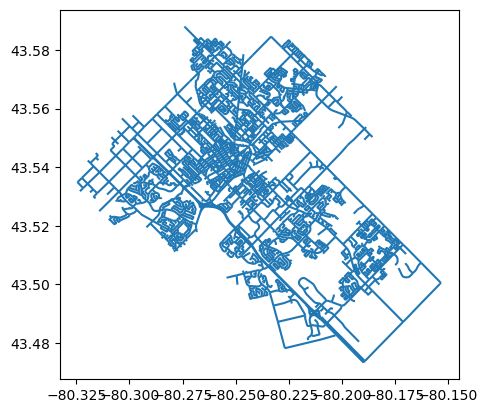

In [209]:
# Quick peak at result
dissolved_streets_gdf.plot()

## JOIN GPS CALL DATA TO GEOJSON STREETS DATA

In [25]:
# Specify which dataframes will be merged
df_gps_merge_in = df_calls_per_street.copy()
gdf_gps_merge_in = dissolved_streets_gdf.copy()

In [36]:
df_gps_merge_in['Address'] = df_gps_merge_in['Address'].str.strip()

In [ ]:
# Use fuzzywuzzy to match slightly different Address and STREET entries
# https://stackoverflow.com/questions/13636848/is-it-possible-to-do-fuzzy-match-merge-with-python-pandas



In [37]:
#df_gps_merge_in.to_csv(r'C:\Users\Shane\Documents\df_gps_merge_in.csv', index=False)
#gdf_gps_merge_in.to_csv(r'C:\Users\Shane\Documents\gdf_gps_merge_in.csv', index=False)

In [38]:
# Merge with `merge` method on shared variable (Address = STREET):
merged = pd.merge(
    gdf_gps_merge_in,
    df_gps_merge_in,
    how="left",
    left_on='STREET',
    right_on='Address',
    left_index=False,
    right_index=False,
    sort=True
    )

print(merged.shape)
print(type(merged))

(1058, 8)
<class 'geopandas.geodataframe.GeoDataFrame'>


In [890]:
df_calls_per_street.head(15)

,Address,gps_calls_sum
0,(UNKNOWN),2
1,10 SIDEROAD NORTH,1
2,21ST ST E,1
3,28 SURREY ST W,1
4,2ND AVE,2
5,721 WOOLWICH ST,30
6,8TH LINE,1
7,ABBEYWOOD CRES,128
8,ABERDEEN ST,51
9,ACKER ST,84


In [39]:
merged.head(10)

,STREET,geometry,MUN,STREETID,SEGMNTID,SHAPE_LEN,Address,gps_calls_sum
0,ABBEYWOOD CR,"LINESTRING (-80.27954 43.52634, -80.27906 43.5...",GUELPH,1018.0,7059.0,0.005880,NaN,NaN
1,ABERDEEN ST,"MULTILINESTRING ((-80.26041 43.54246, -80.2625...",GUELPH,1019.0,6742.0,0.002343,ABERDEEN ST,51.0
2,ACKER ST,"MULTILINESTRING ((-80.22527 43.58087, -80.2241...",GUELPH,3410.0,8258.0,0.001366,ACKER ST,84.0
3,ACORN PL,"LINESTRING (-80.25243 43.56993, -80.25230 43.5...",GUELPH,1021.0,5922.0,0.001003,ACORN PL,44.0
4,ADAMS LN,"LINESTRING (-80.17292 43.51485, -80.17341 43.5...",GUELPH,3569.0,9442.0,0.000605,NaN,NaN
5,ADMIRAL PL,"LINESTRING (-80.20668 43.49083, -80.20787 43.4...",GUELPH,1026.0,4669.0,0.001587,ADMIRAL PL,21.0
6,AIRPARK PL,"LINESTRING (-80.20223 43.56230, -80.19977 43.5...",GUELPH,1027.0,5246.0,0.003060,AIRPARK PL,59.0
7,AJAX ST,"LINESTRING (-80.27450 43.53779, -80.27589 43.5...",GUELPH,1028.0,6829.0,0.001735,AJAX ST,217.0
8,ALBERT ST,"MULTILINESTRING ((-80.24132 43.53792, -80.2425...",GUELPH,1029.0,5078.0,0.001551,ALBERT ST,81.0
9,ALEXANDRA ST,"LINESTRING (-80.26747 43.55782, -80.26663 43.5...",GUELPH,1036.0,6218.0,0.001059,ALEXANDRA ST,22.0


## CLEAN UP THE JOINED DATA

In [ ]:
# Divide number of calls by street segment length to get calls per length metric


## WRITE TO FILE

In [256]:
gdf_output = dissolved_streets_gdf

In [262]:
#gdf_output.to_file('../data/gps.gpkg', driver='GPKG', layer='gps')  
gdf_output.to_file('../data/gps.geojson', driver='GeoJSON')